In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2023-11-23 14:06:45.981846: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-23 14:06:45.981904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-23 14:06:45.982698: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-23 14:06:45.989315: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-23 14:06:46.859665: W tensorflow/compiler/tf2

2.15.0
1.26.1


### 이미지 만들기
티처블머신(https://teachablemachine.withgoogle.com/)
- 웹캠으로 이미지를 만들어서 클래스별로 저장(예. scissor.zip, paper.zip, rock.zip)
- 클라우드에 업로드 한 후 압축을 푼다.(aiffel/scissor_rock_paper/scisscor, ...)


In [2]:
from PIL import Image
import glob
import os

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


### 학습 데이터 만들기
- 각자 생성한 가위바위보 이미지를 모아서 훈련
- 사람별로 정해진 폴더 아래의 paper, scissor, rock에 가위, 바위, 보 이미지를 넣음

#### 이미지 리사이즈
- start_dir_list에 이미지 폴더 리스트를 지정하면 그 폴더들의 하위 폴더를 순회하면서 이미지를 리사이즈함.


In [3]:
def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")  
    
    #rint(len(images), " images to be resized.")
    #print(type(images[0])) #.shape)
    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    
    print(len(images), " images resized.")
    
start_dir_list = ["~/aiffel/rock_scissor_paper", 
                  "~/aiffel/rock_scissor_paper_hh_je/test",
                 "~/aiffel/rock_scissor_paper_org/test"
]

for start_dir in start_dir_list:
    start_dir = os.path.expanduser(start_dir)
    print(start_dir)
    for subdir, _, _ in os.walk(start_dir):
        image_dir_path =  os.path.abspath(subdir)
        print(image_dir_path)
        resize_images(image_dir_path)

print("이미지 resize 완료!")

/home/centillion/aiffel/rock_scissor_paper
/home/centillion/aiffel/rock_scissor_paper_hh_je/test
/home/centillion/aiffel/rock_scissor_paper_org/test
이미지 resize 완료!


### 데이터 로드
- 가위: 0, 바위: 1, 보:2로 라벨링 됨.
- image_path_list에 사용할 이미지 폴더를 여러개 지정하면 그 폴더들 아래의 이미지를 가져와서 라벨링함.
- 이미지를 생성한 사람별로 사용 여부를 결정하기 위해서 이렇게 만들었다.(사진을 어떻게 찍었느냐에 따라 이미지 퀄리티 차이가 많이 남)

In [4]:
import numpy as np
import os

def load_data(img_path, max_number_of_data=10000):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(max_number_of_data*img_size*img_size*color,dtype=np.int32).reshape(max_number_of_data,img_size,img_size,color)
    labels=np.zeros(max_number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path + '/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("데이터의 이미지 개수는", idx,"입니다.")
    imgs = imgs[:idx]
    labels = labels[:idx]

    return imgs, labels

image_path_list = ["~/aiffel/rock_scissor_paper_hh_je",
                   "~/aiffel/rock_scissor_paper_hh_je/test"]
#                   "~/aiffel/rock_scissor_paper_org/train/yeon",
#                   "~/aiffel/rock_scissor_paper_org/train/yeongjin",
#                   "~/aiffel/rock_scissor_paper_org/train/3",
#                   "~/aiffel/rock_scissor_paper_org/test"]
x_data_list = []
y_data_list = []

for image_path in image_path_list:
    image_path = os.path.expanduser(image_path)
    print(image_path)
    (x_data, y_data)=load_data(image_path)
    x_data_list.append(x_data)
    y_data_list.append(y_data.reshape(-1, 1))

x_data = np.vstack(x_data_list)
y_data = np.vstack(y_data_list)

x_data = x_data/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_data shape: {}".format(x_data.shape))
print("y_data shape: {}".format(y_data.shape))

/home/centillion/aiffel/rock_scissor_paper_hh_je
데이터의 이미지 개수는 0 입니다.
/home/centillion/aiffel/rock_scissor_paper_hh_je/test
데이터의 이미지 개수는 0 입니다.
x_data shape: (0, 28, 28, 3)
y_data shape: (0, 1)


In [5]:
print(x_data.shape)
print(y_data.shape)

(0, 28, 28, 3)
(0, 1)


### 모델 정의
- LeNet의 정의을 그대로 따랐다.
- 가장 큰 차이는 convolution layer를 하나 더 넣었다는 것이다.

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers

import numpy as np

# model을 직접 만들어 보세요.
# Hint! model의 입력/출력부에 특히 유의해 주세요. 가위바위보 데이터셋은 MNIST 데이터셋과 어떤 점이 달라졌나요?
n_channel_1=16
n_channel_2=32
n_channel_3=64
n_dense_1= 128
n_dense_2 = 64
n_train_epoch=20

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), \
                              activation='relu', \
                              input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Conv2D(n_channel_3, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
#model.add(keras.layers.Conv2D(n_channel_3, (3,3), activation='relu'))
#model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense_1, activation='relu'))
#model.add(keras.layers.BatchNormalization())  # Batch Normalization
model.add(keras.layers.Dense(n_dense_2, activation='relu'))
#model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()


2023-11-23 14:06:48.309895: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-23 14:06:48.310002: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-23 14:06:48.345475: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-23 14:06:48.345551: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-23 14:06:48.345591: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 1, 1, 64)          0

2023-11-23 14:06:48.761317: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-23 14:06:48.761366: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-23 14:06:48.761404: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-23 14:06:48.761440: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-23 14:06:48.761476: I external/local_xla/xla/stream_executor

### 학습 실행

In [7]:
# model을 학습시키는 코드를 직접 작성해 보세요.
# Hint! model.compile()과 model.fit()을 사용해 봅시다.
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 훈련 데이터의 비율
train_ratio = 0.8
train_size = int(x_data.shape[0] * train_ratio)


# 임의의 인덱스 선택
train_indices = np.random.choice(x_data.shape[0], train_size, replace=False)
eval_indices = np.setdiff1d(np.arange(x_data.shape[0]), train_indices)

# 데이터 분할
x_train = x_data[train_indices]
y_train = y_data[train_indices]
x_eval = x_data[eval_indices]
y_eval = y_data[eval_indices]

print(f"Training data shape: {x_train.shape}")
print(f"Evaluation data shape: {x_eval.shape}")

# 3. 훈련 및 평가
history = model.fit(x_train, y_train, epochs=n_train_epoch, batch_size=32, validation_data=(x_eval, y_eval))



Training data shape: (0, 28, 28, 3)
Evaluation data shape: (0, 28, 28, 3)


ValueError: Expected input data to be non-empty.

### 학습 결과(accuracy, loss) 그래프

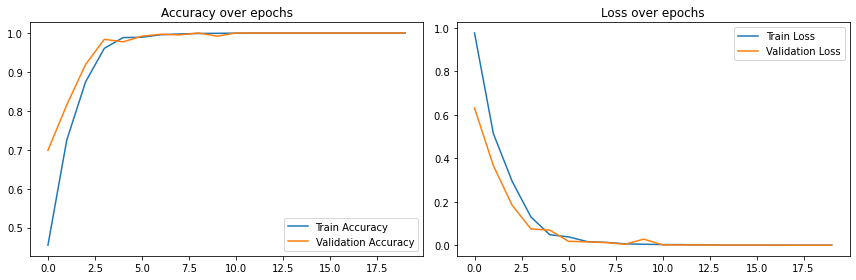

In [ ]:
# 4. 결과를 그래프로 표시
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')

plt.tight_layout()
plt.show()

### 테스트 데이터 불러 오기
- 테스트 데이터는 우리 아이의 가위 바위 보 이미지를 사용했다.
- 정면에서만 예쁘게 찍은 이미지를 사용했다.(정확도를 높이기 위해서)
- 다른 테스트 데이터로는 60%를 넘기기 힘들었다.

117  images resized.
122  images resized.
111  images resized.
/aiffel/aiffel/rock_scissor_paper/test/yeonji/paper
/aiffel/aiffel/rock_scissor_paper/test/yeonji
데이터의 이미지 개수는 350 입니다.


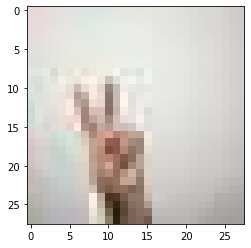

(350, 28, 28, 3)
(350,)


In [ ]:
import matplotlib.pyplot as plt

#test_image_path = "/aiffel/rock_scissor_paper_hh_je/test"
#test_image_path = "/aiffel/rock_scissor_paper_org/test/test"
#test_image_path = "/aiffel/rock_scissor_paper_org/train/3"
test_image_path = "/aiffel/rock_scissor_paper/test/yeonji"


# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + test_image_path + "/scissor"
resize_images(image_dir_path)
image_dir_path = os.getenv("HOME") + test_image_path + "/rock"
resize_images(image_dir_path)
image_dir_path = os.getenv("HOME") + test_image_path + "/paper"
resize_images(image_dir_path)
print(image_dir_path)
image_dir_path = os.getenv("HOME") + test_image_path
print(image_dir_path)
(x_test, y_test)=load_data(image_dir_path)

x_test_norm = x_test/255.0

plt.imshow(x_test[10])
plt.show()

print(x_test_norm.shape)
print(y_test.shape)

### 테스트 정확도 

In [ ]:
# model을 학습시키는 코드를 직접 작성해 보세요.
# Hint! model.evaluate()을 사용해 봅시다.
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print(f"test_loss: {test_loss} ")
print(f"test_accuracy: {test_accuracy}")

11/11 - 0s - loss: 0.2550 - accuracy: 0.9086
test_loss: 0.2550064027309418 
test_accuracy: 0.9085714221000671


### 테스트 추론 결과와 라벨 비교

model.predict() 결과 :  [9.9932480e-01 4.2875774e-09 6.7521579e-04]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  0


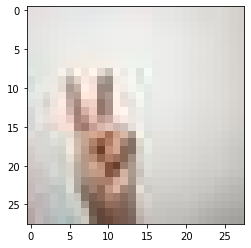

model.predict() 결과 :  [3.3942281e-04 8.6337675e-09 9.9966061e-01]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  2


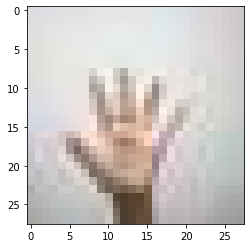

model.predict() 결과 :  [2.6118485e-06 1.0831495e-06 9.9999630e-01]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  2


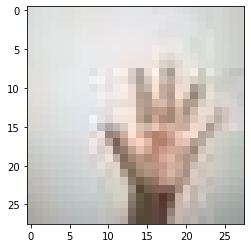

model.predict() 결과 :  [1.1649564e-01 2.6257798e-08 8.8350439e-01]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  2


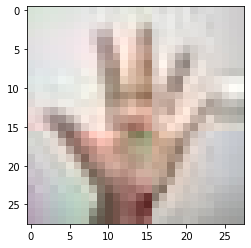

model.predict() 결과 :  [6.117832e-13 1.000000e+00 2.456182e-17]
model이 추론한 가장 가능성이 높은 결과 :  1
실제 데이터의 라벨 :  1


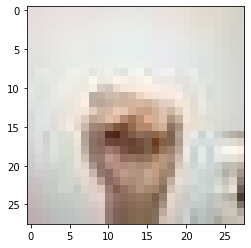

model.predict() 결과 :  [2.4433625e-08 1.0000000e+00 7.4094717e-09]
model이 추론한 가장 가능성이 높은 결과 :  1
실제 데이터의 라벨 :  1


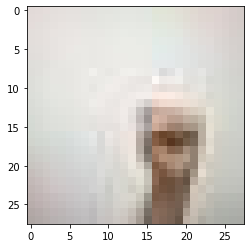

model.predict() 결과 :  [9.993857e-01 6.672334e-08 6.141083e-04]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  0


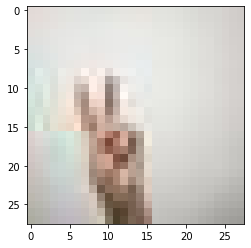

model.predict() 결과 :  [9.6582407e-01 1.2163599e-08 3.4175936e-02]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  2


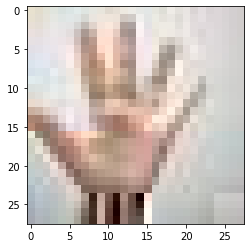

model.predict() 결과 :  [3.3336207e-16 1.0000000e+00 1.0433065e-18]
model이 추론한 가장 가능성이 높은 결과 :  1
실제 데이터의 라벨 :  1


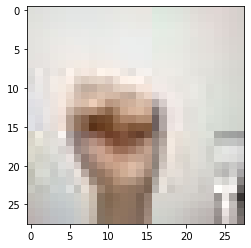

model.predict() 결과 :  [1.000000e+00 6.128349e-11 3.540901e-08]
model이 추론한 가장 가능성이 높은 결과 :  0
실제 데이터의 라벨 :  0


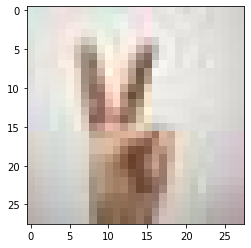

In [ ]:
predicted_result = model.predict(x_test_norm)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

for idx in np.random.choice(len(predicted_labels), 10):
    #idx=150 #1번째 x_test를 살펴보자. 
    print('model.predict() 결과 : ', predicted_result[idx])
    print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
    print('실제 데이터의 라벨 : ', y_test[idx])

    plt.imshow(x_test[idx])
    plt.show()

In [ ]:
# 이미지를 회전해서 저장하는 함수
# - 이미지를 회전 시켜서 학습 시키는데 사용
# - 이미지를 회전했더니 돌아간 부분에 검은 테두리가 생겨서 그런지 학습효과가 좋지는 않았음.
from PIL import Image
import os

def rotate_and_save_images(folder_path):
    # 폴더 내의 모든 파일에 대해
    for filename in os.listdir(folder_path):
        # 이미지 파일만 대상으로
        if filename.endswith('.jpg') or filename.endswith('.png'):  # 다른 확장자도 추가 가능
            image_path = os.path.join(folder_path, filename)
            img = Image.open(image_path)

            # 90도, 180도, 270도 회전하고 저장
            for angle in [-15, 15, 30, 45]:
                rotated_img = img.rotate(angle)
                new_filename = f"{filename.split('.')[0]}_{angle}.jpg"  # 원본 파일 이름에 각도를 추가
                rotated_img.save(os.path.join(folder_path, new_filename))

# 폴더 경로 지정
#folder_path = '/aiffel/rock_scissor_paper/rock'
rotate_and_save_images('/aiffel/aiffel/rock_scissor_paper/rock')
rotate_and_save_images('/aiffel/aiffel/rock_scissor_paper/paper')
rotate_and_save_images('/aiffel/aiffel/rock_scissor_paper/scissor')
